In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, f1_score, make_scorer
)
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

%load_ext autoreload
%autoreload 2

from funs.utils import find_best_threshold
from funs.plots import plot_roc, plot_confusion_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
df = pd.read_csv("../../data/processed/filtered_data.csv")

In [66]:
TARGET = 'is_fraud'

X = df[df.columns.difference([TARGET])]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

XGBClassifier

In [67]:
params = {
    'objective':        'binary:logistic',
    'eval_metric':      'auc',
    'scale_pos_weight': 12.5,
    'learning_rate':    0.01,
    'n_estimators':     700,
    'max_depth':        6,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'random_state':     42,
}

model = XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=700,
              n_jobs=None, num_parallel_tree=None, ...)

#### Finding optimal probability treshold

In [68]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

best_thresh, best_f1 = find_best_threshold(y_test, y_pred_prob, metric='f1', verbose=False)
print(f"\nBest Threshold: {best_thresh:.2f} with F1 score: {best_f1:.4f}")

y_pred = (y_pred_prob >= best_thresh).astype(int)


Best Threshold: 0.64 with F1 score: 0.2551


Model evaluation

In [69]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


Confusion Matrix:
[[91614 22783]
 [ 5721  4882]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9412    0.8008    0.8654    114397
           1     0.1765    0.4604    0.2551     10603

    accuracy                         0.7720    125000
   macro avg     0.5588    0.6306    0.5603    125000
weighted avg     0.8764    0.7720    0.8136    125000

ROC AUC: 0.7181


In [ ]:
plot_roc(y_test, y_pred_prob)

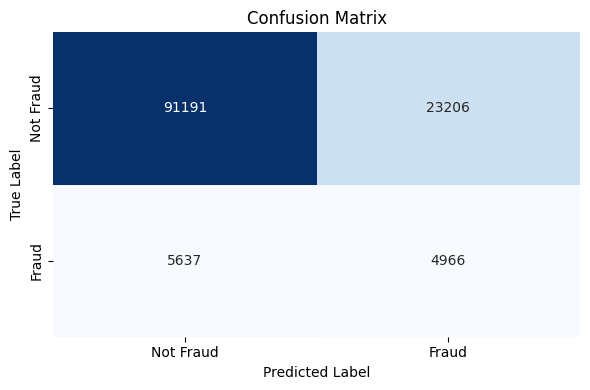

In [14]:
plot_confusion_matrix(y_test, y_pred)

Features importance

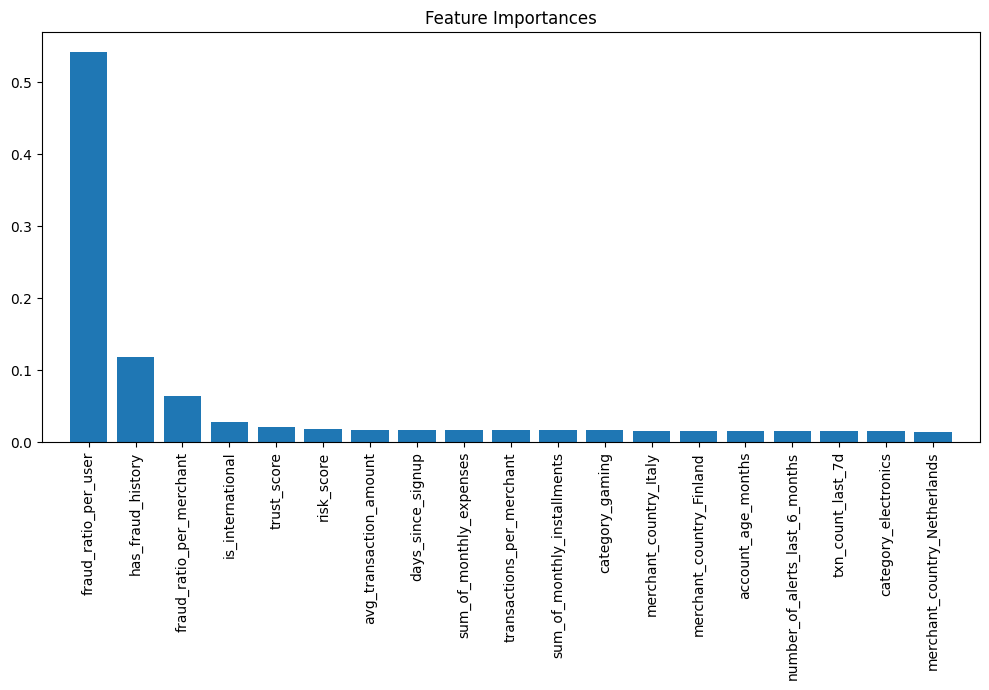

In [70]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 7))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(df.columns.difference([TARGET]))[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

#### Logistic regression

Best parameters: {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}

Best Threshold: 0.11 with F1 score: 0.2559

Confusion Matrix:
[[90856 23541]
 [ 5593  5010]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9420    0.7942    0.8618    114397
           1     0.1755    0.4725    0.2559     10603

    accuracy                         0.7669    125000
   macro avg     0.5587    0.6334    0.5589    125000
weighted avg     0.8770    0.7669    0.8104    125000

ROC AUC: 0.7184


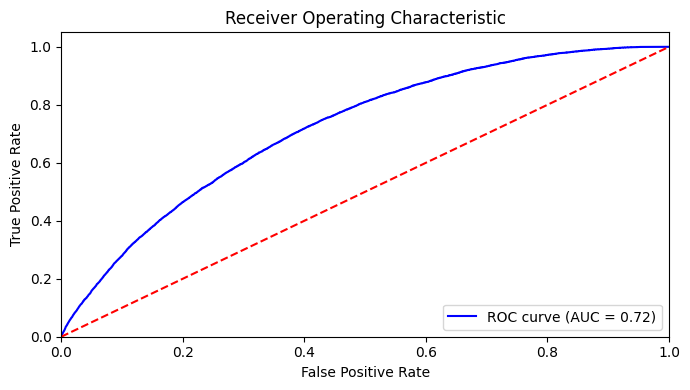

In [72]:
# TODO: REFACTOR CODE
# ^^^
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, random_state=42)
)
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100], 
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']
}
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='f1',
    cv=5,
    n_jobs=-1
)   

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

y_pred_prob = best_model.predict_proba(X_test)[:, 1]
best_thresh, best_f1 = find_best_threshold(y_test, y_pred_prob, metric='f1', verbose=False)
print(f"\nBest Threshold: {best_thresh:.2f} with F1 score: {best_f1:.4f}")
y_pred = (y_pred_prob >= best_thresh).astype(int)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
plot_roc(y_test, y_pred_prob)

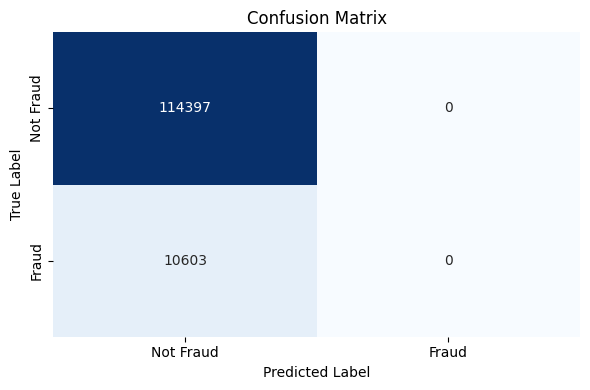

Dummy Model Accuracy: 0.9152
Dummy Model ROC AUC: 0.5000


In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

dummy_y_pred = dummy_model.predict(X_test)
dummy_y_pred_prob = dummy_model.predict_proba(X_test)[:, 1]
plot_confusion_matrix(y_test, dummy_y_pred)
dummy_accuracy = accuracy_score(y_test, dummy_y_pred)
dummy_roc_auc = roc_auc_score(y_test, dummy_y_pred_prob)

print(f"Dummy Model Accuracy: {dummy_accuracy:.4f}")
print(f"Dummy Model ROC AUC: {dummy_roc_auc:.4f}")